In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import healpy as hp
import pandas as pd
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

## JLA data

http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html

The JLA (Joint Light-Curve Analysis) dataset comprises $740$ spectroscopically confirmed Type Ia Supernovae drawn from SDSS, SNLS and several other experiments. A Type Ia Supernova occurs when a white dwarf accretes enough mass from a nearby object in order to ignite a thermonuclear explosion. These supernovae can be standardised and hence serve as distance indicators. In order to standardise them, one first needs to take into account that brighter supernovae shine for a longer time. The apparent brightness in the sky allows to measure the apparent magnitude, while the time scale for the decline of the brightness allows to estimate the absolute magnitude, and hence determine the luminosity distance of the object. In addition, one needs to perform a colour correction because brighter supernovae are bluer in colour. In this way for each standardised supernova we get a measurement of the luminosity distance and the redshift.

In [3]:
def create_df(filename):
    """A function to load the relevant data from a JLA txt file onto a Pandas dataframe."""
    data = np.loadtxt(filename, skiprows=1, usecols=[1, 4, 5])
    redshift = data[:, 0]
    magn = data[:, 1]
    dm = data[:, 2]
    #absolute magnitude
    Mb = -19.5
    #transform the apparent magnitude into a luminosity distance
    lum_dist = 10**((magn - Mb)/5 - 5)
    ddl = dm * np.log(10)/5 * lum_dist
    angles = np.loadtxt(filename, skiprows=1, usecols=[-3, -2])
    ra = angles[:, 0]
    dec = angles[:, 1]
    supnovae = {'Redshift':redshift, 'Luminosity distance':lum_dist, 
                "Luminosity distance error":ddl, 'RA':ra, 'Declination':dec}
    df = pd.DataFrame(supnovae)
    return df

In [4]:
df = create_df('jla_lcparams.txt')

In [5]:
df

,Redshift,Luminosity distance,Luminosity distance error,RA,Declination
0,0.503084,3164.751395,128.298305,36.043210,-4.037469
1,0.580724,4118.958345,170.966922,36.061634,-4.517158
2,0.494795,3104.758323,125.979153,36.097287,-4.720774
3,0.345928,2396.775739,96.317061,36.657235,-4.838779
4,0.677662,5195.447971,235.325799,36.567748,-4.935050
...,...,...,...,...,...
735,0.027064,158.781975,10.360262,275.765000,29.897050
736,0.025468,114.701633,7.576214,333.668430,5.080160
737,0.023810,119.977608,7.973653,195.812750,50.618760
738,0.023867,129.913296,8.636068,358.553990,27.409170


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 5 columns):
Redshift                     740 non-null float64
Luminosity distance          740 non-null float64
Luminosity distance error    740 non-null float64
RA                           740 non-null float64
Declination                  740 non-null float64
dtypes: float64(5)
memory usage: 29.0 KB


In [7]:
df[['Redshift', 'Luminosity distance']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Redshift,740.0,0.323804,0.276869,0.010060,0.124240,0.229045,0.498216,1.299106
Luminosity distance,740.0,2136.903705,2068.180811,53.664143,703.335167,1317.617639,3226.223703,12863.382979


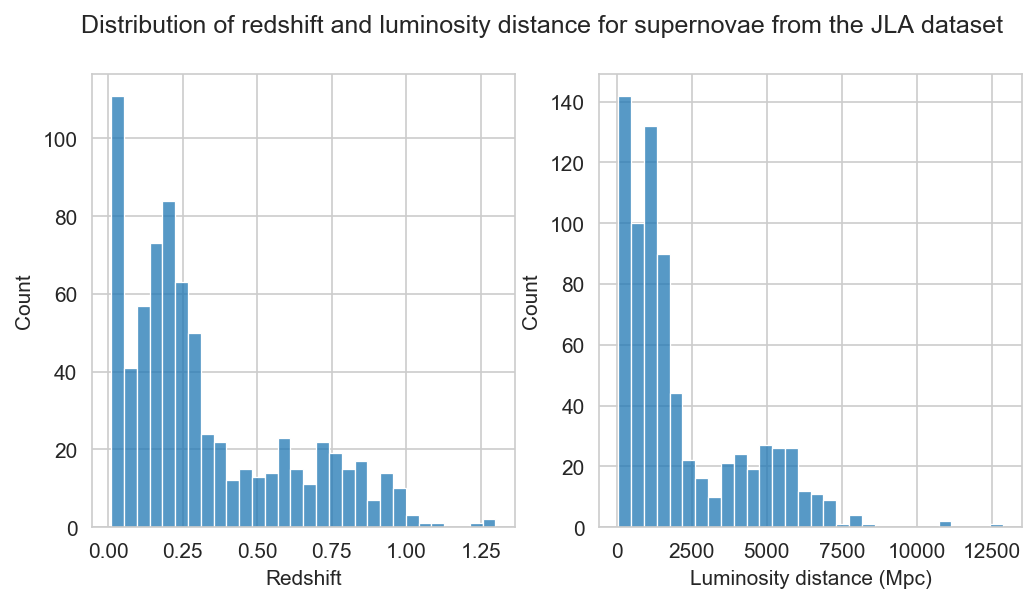

In [8]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4), dpi=150)
#plot distribution of redshift and luminosity distance (in Mpc) for supernovae from JLA
sns.histplot(data=df, x='Redshift', bins=30, ax=axes[0]);
sns.histplot(data=df, x='Luminosity distance', bins=30, ax=axes[1])
axes[1].set_xlabel('Luminosity distance (Mpc)')
plt.suptitle('Distribution of redshift and luminosity distance for supernovae from the JLA dataset')
plt.show()

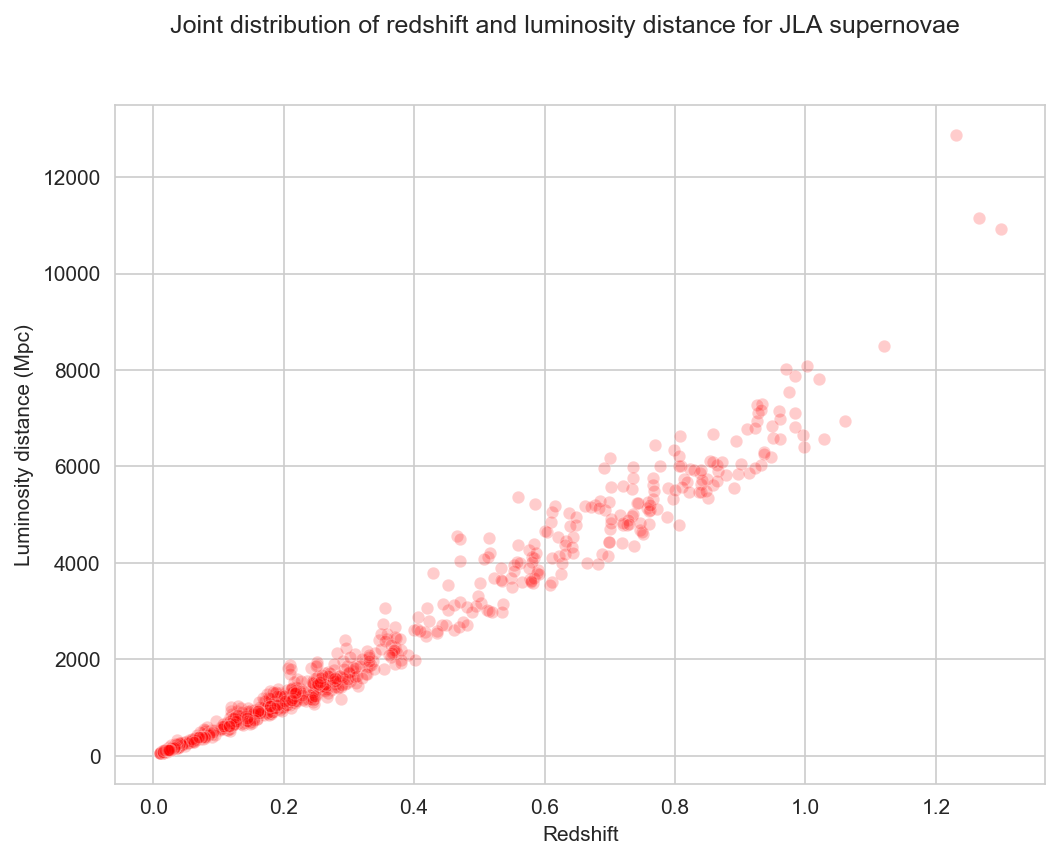

In [9]:
plt.figure(figsize=(8,6), dpi=150)

sns.scatterplot(data=df, x='Redshift', y='Luminosity distance', alpha=0.2, color='red')
plt.ylabel('Luminosity distance (Mpc)')
plt.suptitle('Joint distribution of redshift and luminosity distance for JLA supernovae')
plt.show()

In [10]:
def load_data(df, nside=32, z_min=0.01, z_max=0.02):
    """Load the data from a dataframe in a particular redshift bin. It gives an array of the luminosity distance
    to be plotted on healpix."""
    df_filt = df[np.logical_and(df['Redshift']>=z_min, df['Redshift']<z_max)]
    npix = 12*nside**2
    data_layout = [[] for i in range(npix)]
    sdata = np.empty(npix)
    for index, row in df_filt.iterrows():
        k = hp.ang2pix(nside, np.pi/2 - row['Declination']*np.pi/180, row['RA']*np.pi/180)
        data_layout[k].append(row['Luminosity distance'])
    for n in range(npix):
        if data_layout[n] == []:
            sdata[n] = 0
        else:
            sdata[n] = np.mean(np.array(data_layout[n]))
    return sdata

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


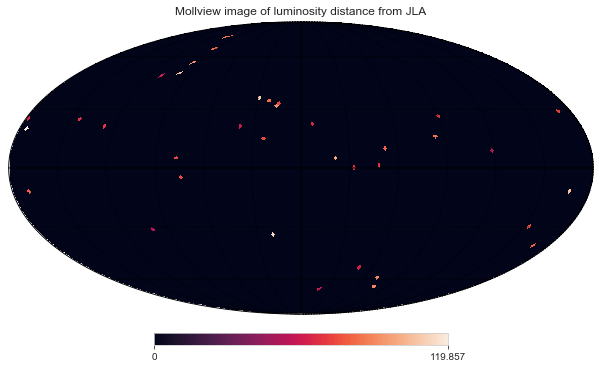

In [11]:
#as an example, we load the redshift range 0.01-0.02
sup_data = load_data(df, nside=32, z_min=0.01, z_max=0.02)
#plot an image of dl in the sky
hp.mollview(sup_data, title="Mollview image of luminosity distance from JLA") 
hp.graticule()

## The $\Lambda$CDM model

We define the main parameters that will be used later on:

In [12]:
#Definition of the main constants
H_0 = 67.66      #Hubble constant
H0s = 22.5*10**(-19)      #Hubble constant in units of seconds
c = 3*10**5      #speed of light
alpha = 0.01      #significance level
OmegaL0 = 0.691      #dark energy parameter
Omegam0 = 0.309      #matter parameter
zeq = (OmegaL0/Omegam0)**(1/3)-1      #redshift at matter - dark energy equality
aeq = (Omegam0/OmegaL0)**(1/3)      #scale factor at matter - dark energy equality
teq = 1.5 * OmegaL0**(-0.5)/H0s * np.arcsinh(1)      #cosmological time at matter - dark energy equality
Teq = 1/np.sqrt(2) * OmegaL0**(-0.5) * H0s**(-1)      #time scale for transition from MD to LD

In [13]:
zeq, teq, Teq

(0.30769517898930787, 7.068540467767949e+17, 3.7806237683706304e+17)

In [14]:
def dl_lcdm(z):
    """The luminosity distance in LCDM as a function of redshift."""
    def f(x):
        return (Omegam0*x**3 + OmegaL0)**(-0.5)
    s, err = quad(f, 1, 1 + z)
    return (c/H_0)*(1+z)*s

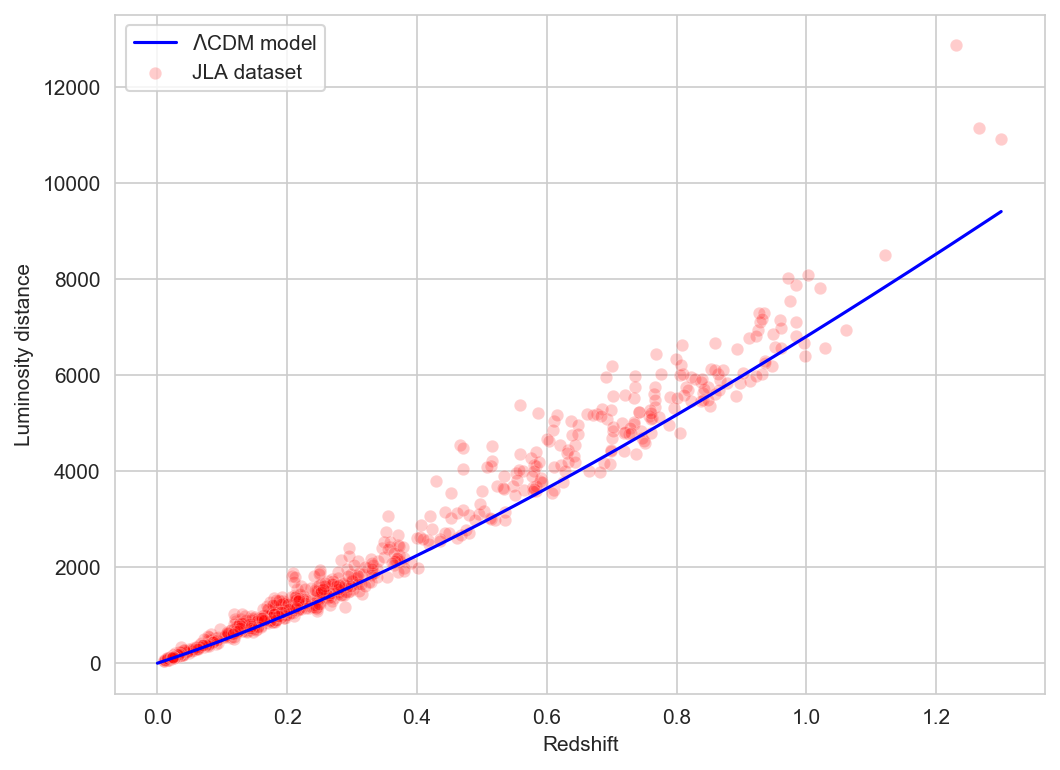

In [15]:
z_sam = np.arange(0, 1.31, 0.01)
lcdm_values = np.empty(len(z_sam))
for i in range(len(z_sam)):
    lcdm_values[i] = dl_lcdm(z_sam[i])
    
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

sns.scatterplot(ax=ax, data=df, x='Redshift', y='Luminosity distance', alpha=0.2, 
                color='red', label="JLA dataset");

ax.plot(z_sam, lcdm_values, color='blue', label="$\Lambda$CDM model")
plt.legend(loc='upper left')
plt.show()

## An anisotropic model

The metric in the anisotropic model is
\begin{align}
ds^2 &= - dt^2 + a^2(t) [ \epsilon^2(t) (dx^2 + dy^2) + dz^2 ] \nonumber \\
&= a^2(\eta) [ - d\eta^2 + \epsilon^2(\eta) (dx^2 + dy^2) + dz^2 ] \nonumber \\
&= a^2(\eta) d \tilde{s}^2,
\end{align}
where
\begin{align}
d \tilde{s}^2 &= - d\eta^2 + \epsilon^2(\eta) (dx^2 + dy^2) + dz^2 \nonumber \\
&=  \epsilon^2(\tau) [ -d \tau^2 + dx^2 + dy^2 ] + dz^2 \nonumber \\
&= \epsilon^2(\tau) d \hat{s}^{2} + dz^2,
\end{align}
where
\begin{align}
d \hat{s}^{2} &= -d \tau^2 + dx^2 + dy^2  \nonumber \\
&= -d \tau^2 + dr^2.
\end{align}

Under conformal transformations $ds^2 = f^2 (x) d s^{'2}$, the luminosity distance transforms as:
\begin{equation}
d_L = \frac{f^2_o}{f_s} d_L^{'}.
\end{equation}

Also the luminosity distance in $d+1$ dimensions is related to the luminosity distance in $d$ dimensions by
\begin{equation}
d_L^{(d+1)} = \sqrt{d_L^{(d) 2} + z^2}.
\end{equation}

Therefore, we have
\begin{equation}
\hat{d}_L = r,
\end{equation}
\begin{equation}
\tilde{d}_L = \sqrt{\frac{\epsilon^4_o}{\epsilon^2_s}r^2 + z^2},
\end{equation}
\begin{equation}
d_L = \frac{a^2_o}{a_s} \sqrt{\frac{\epsilon^4_o}{\epsilon^2_s}r^2 + z^2}.
\end{equation}

If we set $z = R \mathrm{cos} \theta$ and $r = R \mathrm{sin} \theta$, the latter simplifies to
\begin{align}
d_L &= \frac{a^2_o}{a_s} R \sqrt{\frac{\epsilon^4_o}{\epsilon^2_s} \mathrm{sin}^2 \theta + \mathrm{cos}^2 \theta} \nonumber \\
&= d_{L, FRW} \sqrt{\frac{\epsilon^4_o}{\epsilon^2_s} \mathrm{sin}^2 \theta + \mathrm{cos}^2 \theta}.
\end{align}

The function $\epsilon(t)$ is assumed to be of the form
\begin{equation}
\epsilon(t) = - \Big(\frac{1}{2} - \frac{\epsilon_0}{2} \Big) \mathrm{tanh} \Big( \frac{t-t_{eq}}{T_{eq}} \Big) + \frac{1}{2} + \frac{\epsilon_0}{2},
\end{equation}
where $\epsilon_0$ and $T_{eq}$ are constants.

In [16]:
def eps(t, e0=0.84, T=Teq):
    """Epsilon as a function of cosmological time."""
    return -(0.5 - e0/2) * np.tanh((t-teq)/T) + 0.5 + e0/2

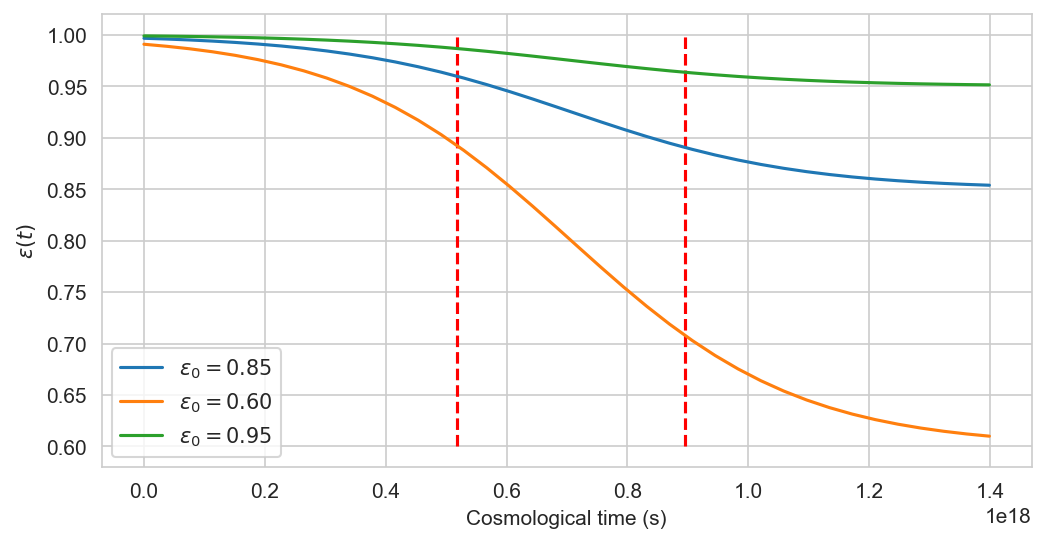

In [17]:
l = teq/Teq
t_values = Teq * np.arange(-l, l, 0.1) + teq
eps_values1 = eps(t_values, e0=0.85)
eps_values2 = eps(t_values, e0=0.6)
eps_values3 = eps(t_values, e0=0.95)

fig, ax = plt.subplots(figsize=(8,4), dpi=150)

ax.plot(t_values, eps_values1, label='$\epsilon_0 = 0.85$')
ax.plot(t_values, eps_values2, label='$\epsilon_0 = 0.60$')
ax.plot(t_values, eps_values3, label='$\epsilon_0 = 0.95$')
ax.vlines(teq - Teq/2, 0.6, 1, color='red', linestyle='dashed')
ax.vlines(teq + Teq/2, 0.6, 1, color='red', linestyle='dashed')
ax.set_xlabel('Cosmological time (s)')
ax.set_ylabel('$\epsilon(t)$')

plt.legend(loc='lower left')
plt.show()

We want to solve for the evolution of the scale factor $a(t)$ during the time of matter-$\Lambda$ equality, i.e. to solve the Friedmann equation with both components present:
\begin{equation}
\dot{a}^2 = \frac{4 \pi G}{3} \rho_{eq} a_{eq}^3 \frac{1}{a} + \frac{4 \pi G}{3} \rho_{eq} a^2
\end{equation}
The solution to this equation with the IC $a(t=0) = 0$ is:
\begin{equation}
a = a_{eq} \Big[ \mathrm{sinh} \Big( \frac{3}{2} \sqrt{\frac{4 \pi G}{3} \rho_{eq}} t \Big) \Big]^{2/3}
\end{equation}
Inverting that we get:
\begin{equation}
t(a) = \frac{3}{2} \Big( \frac{4 \pi G}{3} \rho_{eq} \Big)^{-1/2} \mathrm{arcsinh} \Big[ \Big( \frac{a}{a_{eq}} \Big)^{3/2} \Big]
\end{equation}
Using $a = (1+z)^{-1}$ this can be rewritten as
\begin{equation}
t(z) = \frac{3}{2} \Big( \frac{4 \pi G}{3} \rho_{eq} \Big)^{-1/2} \mathrm{arcsinh} \Big[ \Big( \frac{1+z_{eq}}{1+z} \Big)^{3/2} \Big]
\end{equation}
or
\begin{equation}
t(z) = \frac{3}{2} \Omega_{\Lambda,0}^{-1/2} H_0^{-1} \mathrm{arcsinh} \Big[ \Big( \frac{1+z_{eq}}{1+z} \Big)^{3/2} \Big]
\end{equation}
The time of equality is given by
\begin{equation}
t_{eq} = \frac{3}{2} \Omega_{\Lambda,0}^{-1/2} H_0^{-1} \mathrm{arcsinh} [1]
\end{equation}

In [18]:
def t(z):
    """Cosmological time as a function of redshift for FRW with matter and dark energy components."""
    return 1.5 * OmegaL0**(-0.5)/H0s * np.arcsinh(((1+zeq)/(1+z))**1.5)

In [19]:
def Eps(z, e0=0.84, T=Teq):
    """Epsilon as a function of redshift."""
    return eps(t(z), e0=e0, T=T)

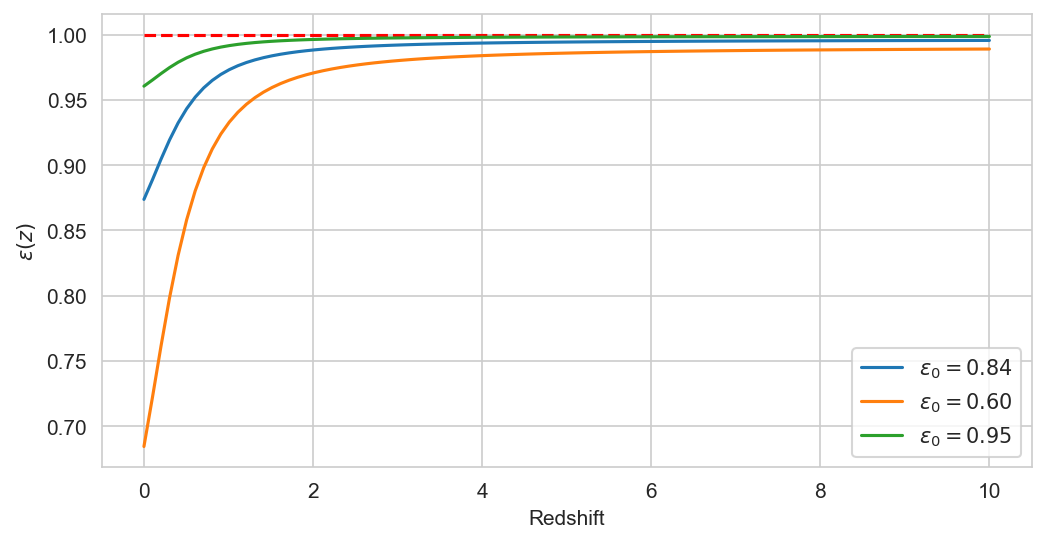

In [20]:
z_values = np.linspace(0, 10, 100)
e_values1 = Eps(z_values, e0=0.84)
e_values2 = Eps(z_values, e0=0.6)
e_values3 = Eps(z_values, e0=0.95)

fig, ax = plt.subplots(figsize=(8,4), dpi=150)

ax.plot(z_values, e_values1, label='$\epsilon_0 = 0.84$')
ax.plot(z_values, e_values2, label='$\epsilon_0 = 0.60$')
ax.plot(z_values, e_values3, label='$\epsilon_0 = 0.95$')
ax.hlines(1, 0, 10, color='red', linestyle='dashed')
ax.set_xlabel("Redshift")
ax.set_ylabel('$\epsilon(z)$')

plt.legend(loc='lower right')
plt.show()

In [21]:
def dl_anis(z, theta, phi, e0=0.85, T=Teq):
    """The luminosity distance in the anisotropic (tanh) model as a function of redshift and the polar angles."""
    return dl_lcdm(z) * np.sqrt(Eps(0, e0=e0)**4/Eps(z, e0=e0)**2 * np.sin(theta)**2 + np.cos(theta)**2)

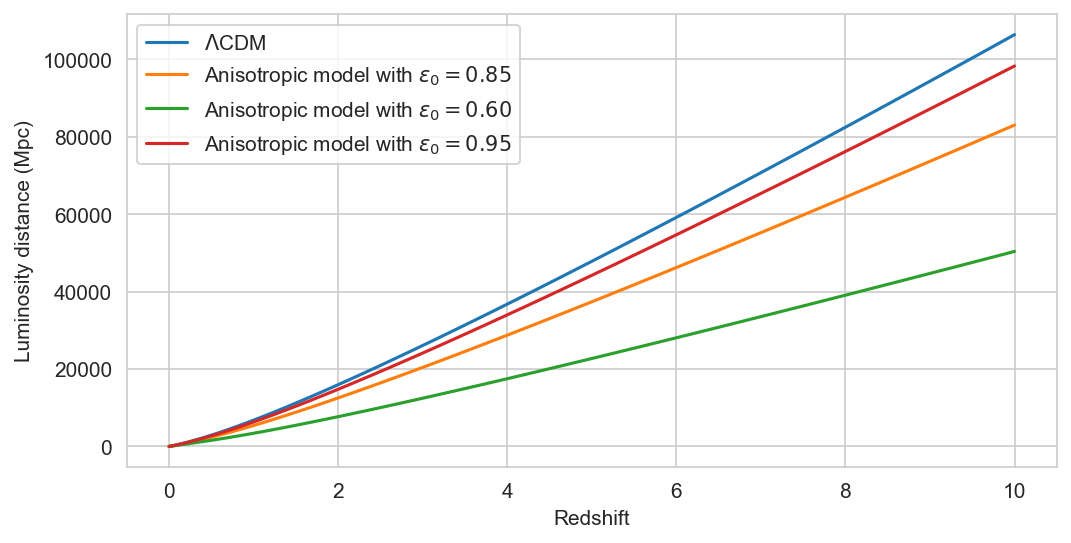

In [22]:
z_values = np.linspace(0,10,100)
dl_lcdm_values = []
for z in z_values:
    dl_lcdm_values.append(dl_lcdm(z))
dl_anis_values1 = []
for z in z_values:
    dl_anis_values1.append(dl_anis(z, np.pi/2, 0, e0=0.85))
dl_anis_values2 = []
for z in z_values:
    dl_anis_values2.append(dl_anis(z, np.pi/2, 0, e0=0.6))
dl_anis_values3 = []
for z in z_values:
    dl_anis_values3.append(dl_anis(z, np.pi/2, 0, e0=0.95))

fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    
ax.plot(z_values, dl_lcdm_values, label='$\Lambda$CDM')
ax.plot(z_values, dl_anis_values1, label='Anisotropic model with $\epsilon_0=0.85$')
ax.plot(z_values, dl_anis_values2, label='Anisotropic model with $\epsilon_0=0.60$')
ax.plot(z_values, dl_anis_values3, label='Anisotropic model with $\epsilon_0=0.95$')
ax.set_xlabel("Redshift")
ax.set_ylabel('Luminosity distance (Mpc)')

plt.legend(loc='upper left')
plt.show()

## Testing the isotropy assumption with mock data

The currently available data from the JLA dataset is not sufficient in order to determine whether it is drawn from an isotropic distribution in the sky, i.e. whether the Universe is isotropic on large scales. However, we can perform an analysis with mock data drawn from the anisotropic model in order to determine how many supernovae we would need in the future in order to distinguish between the $\Lambda$CDM and the anisotropic model for various different values of the model and data parameters.

The anisotropic model is parametrised by a single extra parameter compared to $\Lambda$CDM - $\epsilon_0$ which gives the maximal possible deviation from isotropy. The mock data is parametrised by two parameters - $q$ the fraction of pixels in a disc in the sky that are empty (thus $1-q$ is the fraction of pixels that contain a supernova), and $s$ - the average error of each measurement (assumed to be Gaussian).

In [23]:
def populate_disc_with_holes(z, disc, e0=0.85, T=Teq, q=0.7, scatter=1/20, NSIDE=32):
    """A function to generate a disc in the sky with NSIDE=32 pixelisation where 1-q of the pixels are filled
    with a value of the luminosity distance with mean of dl_tanh(z) and gaussian scatter of std=mean/10"""
    disc_pop = np.empty(len(disc)) #initialise an empty disc
    for i in range(len(disc)):
        if np.random.random() < q:  #a fraction q of the pixels in a disc are empty
            disc_pop[i] = 0
        else:
            #the rest are populated with theoretical values for a fixed z with a gaussian scatter
            dl = dl_anis(z, hp.pix2ang(NSIDE, disc[i])[0], hp.pix2ang(NSIDE, disc[i])[1], e0=e0, T=T) 
            disc_pop[i] = np.random.normal(loc=dl, scale=dl*scatter)  
    return disc_pop

In [24]:
def gen_cat_at_angle(z, *args, e0=0.85, T=Teq, q=0.7, scatter=1/20, NSIDE=32):
    """A function that takes several discs in the sky (*args) and populates them with mock data"""
    NPIX = hp.nside2npix(NSIDE) #number of pixels
    cat = np.array([0 for i in range(NPIX)]) #initialise 0 for every pixel in the sky
    dl = [0 for i in range(len(args))] #initial value of 0 for dl for every disc in the sky
    for i in range(len(args)):
        #populate every disc according to previous function; dl is a 2d array
        dl[i] = populate_disc_with_holes(z, args[i], e0=e0, T=T, q=q, scatter=scatter, NSIDE=NSIDE) 
        #populate catalog with corresponding dl values; cat is a 1d array
        cat[args[i]] = dl[i]
    return cat, dl

In order to illustrate how the approach work, we test for a deviation from isotropy by using two mock datasets - the first where there is a large anisotropy present (thus $\epsilon_0$ is small), the second where the anisotropy is negligible (thus $\epsilon_0$ is very close to $1$).

### Case 1: large anisotropy (small $\epsilon_0$)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


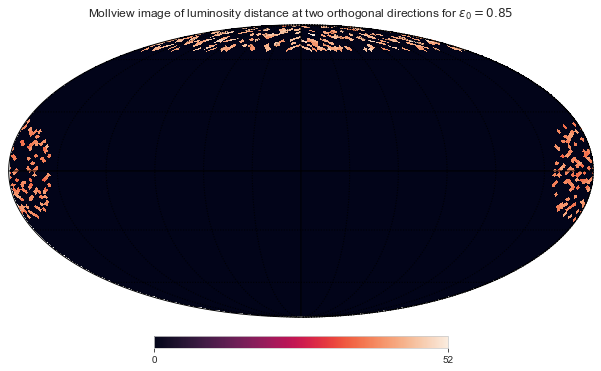

In [39]:
vec1 = hp.ang2vec(0, 0)
vec2 = hp.ang2vec(np.pi/2, np.pi)
ipix_disc1 = hp.query_disc(nside=32, vec=vec1, radius=np.radians(25))
ipix_disc2 = hp.query_disc(nside=32, vec=vec2, radius=np.radians(25))
#create two discs one at the north pole, another at the equator; populate them with values from tanh model
cat2dir, dl2dir = gen_cat_at_angle(0.01, ipix_disc1, ipix_disc2)
hp.mollview(cat2dir, title="Mollview image of luminosity distance at two orthogonal directions for $\epsilon_0 = 0.85$")
hp.graticule()

In [40]:
def draw_perm_reps(data1, data2, test_stat, size=10000):
    """A function to draw permutation replicates of a given test statistic from two
    patches of data"""
    test_stat_distr = np.empty(size)
    for i in range(size):
        data12 = np.concatenate((data1, data2))
        sample = np.random.permutation(data12)
        sample1 = sample[:len(data1)]
        sample2 = sample[len(data1):]
        test_stat_distr[i] = test_stat(sample1, sample2)
    return test_stat_distr

In [41]:
def diff_of_means(data1, data2):
    """The test statistic that we will use is the difference in the means."""
    return np.mean(data1) - np.mean(data2)

In [42]:
dl1 = np.array(dl2dir[0])
dl2 = np.array(dl2dir[1])
dl1_filt = dl1[dl1>0]
dl2_filt = dl2[dl2>0]

In [43]:
diff_obs = diff_of_means(dl1_filt, dl2_filt)
print(diff_obs)

4.98907094356683


In [44]:
perm_reps = draw_perm_reps(dl1_filt, dl2_filt, diff_of_means)
conf_int_perm = np.percentile(perm_reps, [0.5, 99.5])
p_var = np.sum(perm_reps >= diff_obs) / len(perm_reps)
if p_var > 0.5:
    p_var = 1-p_var
print('p-value: ', p_var)
if p_var < alpha:
    print('Null hypothesis is rejected. Signal for an anisotropy!')
else:
    print('Null hypothesis is NOT rejected. NO signal for an anisotropy!')

p-value:  0.0
Null hypothesis is rejected. Signal for an anisotropy!


In [45]:
perm_mean = np.mean(perm_reps)
perm_std = np.std(perm_reps)

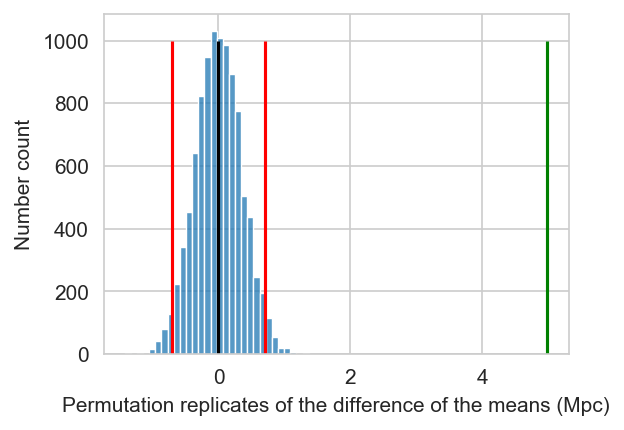

In [46]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)

sns.histplot(perm_reps, bins=30, ax=ax)
ax.vlines(diff_obs, 0, 1000, color='green')
ax.vlines(perm_mean, 0, 1000, color='black')
ax.vlines(perm_mean + 2*perm_std, 0, 1000, color='red')
ax.vlines(perm_mean - 2*perm_std, 0, 1000, color='red')
ax.set_xlabel('Permutation replicates of the difference of the means (Mpc)')
ax.set_ylabel('Number count')
plt.show()

The blue histogram shows the distribution of the permutation replicates. It is an approximation of the distribution of the test statistic under the assumption that the null hypothesis (Universe is isotropic) is correct. The green line shows the expection from the mock data. The large discrepancy leads to a rejection of the null hypothesis.

### Case 2: small anisotropy (large $\epsilon$)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


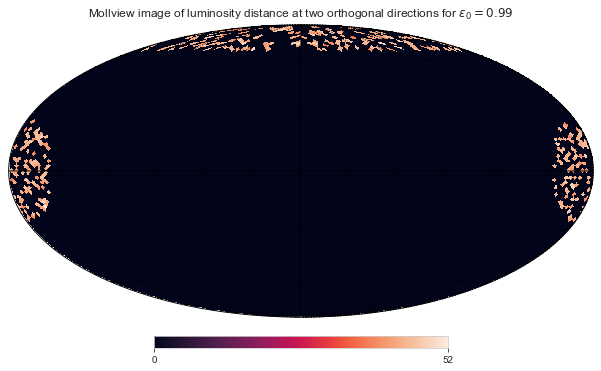

In [47]:
v1 = hp.ang2vec(0, 0)
v2 = hp.ang2vec(np.pi/2, np.pi)
disc1 = hp.query_disc(nside=32, vec=v1, radius=np.radians(25))
disc2 = hp.query_disc(nside=32, vec=v2, radius=np.radians(25))
#create two discs one at the north pole, another at the equator; populate them with values from tanh model
cat, dl = gen_cat_at_angle(0.01, disc1, disc2, e0=0.99)
hp.mollview(cat, title="Mollview image of luminosity distance at two orthogonal directions for $\epsilon_0 = 0.99$")
hp.graticule()

In [48]:
dl1s = np.array(dl[0])
dl2s = np.array(dl[1])
dl1_filts = dl1s[dl1s>0]
dl2_filts = dl2s[dl2s>0]

In [49]:
diff_obs_s = diff_of_means(dl1_filts, dl2_filts)
print(diff_obs_s)

0.12156858514831015


In [50]:
perm_reps_s = draw_perm_reps(dl1_filts, dl2_filts, diff_of_means)
conf_int_perm = np.percentile(perm_reps_s, [0.5, 99.5])
p = np.sum(perm_reps_s >= diff_obs_s) / len(perm_reps_s)
if p > 0.5:
    p = 1-p
print('p-value: ', p)
if p < alpha:
    print('Null hypothesis is rejected. Signal for an anisotropy!')
else:
    print('Null hypothesis is NOT rejected. NO signal for an anisotropy!')

p-value:  0.3194
Null hypothesis is NOT rejected. NO signal for an anisotropy!


In [51]:
perm_mean_s = np.mean(perm_reps_s)
perm_std_s = np.std(perm_reps_s)

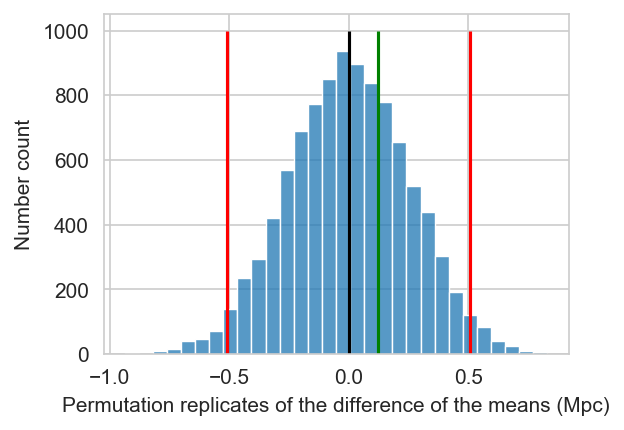

In [52]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)

sns.histplot(perm_reps_s, bins=30, ax=ax)
ax.vlines(diff_obs_s, 0, 1000, color='green')
ax.vlines(perm_mean_s, 0, 1000, color='black')
ax.vlines(perm_mean_s + 2*perm_std_s, 0, 1000, color='red')
ax.vlines(perm_mean_s - 2*perm_std_s, 0, 1000, color='red')
ax.set_xlabel('Permutation replicates of the difference of the means (Mpc)')
ax.set_ylabel('Number count')
plt.show()

In this case the mock data is consistent with an isotropic Universe and therefore we fail to reject the null hypothesis.

### Testing for an anisotropic signal in mock data generated for different values of the parameters $\epsilon_0$, $q$, $s$

In [53]:
def run_test(z, e0=0.84, T=Teq, q=0.7, scatter=1/20, NSIDE=32):
    """A function that takes the input parameters, runs a permutation test and outputs the tension between the LCDM
    model and mock data generated from the anisotropic model for these values of the parameters."""
    vec1 = hp.ang2vec(0, 0) #pick two orthogonal directions in the sky
    vec2 = hp.ang2vec(np.pi/2, np.pi)
    ipix_disc1 = hp.query_disc(nside=NSIDE, vec=vec1, radius=np.radians(25)) #look at discs in these directions
    ipix_disc2 = hp.query_disc(nside=NSIDE, vec=vec2, radius=np.radians(25))
    cat2dir, dl2dir = gen_cat_at_angle(z, ipix_disc1, ipix_disc2, e0=e0, T=T, q=q, scatter=scatter, NSIDE=NSIDE)
    #generate mock data in these two discs
    dl1 = np.array(dl2dir[0])
    dl2 = np.array(dl2dir[1])
    dl1_filt = dl1[dl1>0]
    dl2_filt = dl2[dl2>0] #filter data to get two arrays of luminosity distance
    diff_obs = diff_of_means(dl1_filt, dl2_filt) #find test statistic for mock data
    
    perm_reps = draw_perm_reps(dl1_filt, dl2_filt, diff_of_means)
    #draw permutation replicates i.e. simulate the null hypothesis of isotropic distribution
    perm_mean = np.mean(perm_reps)
    perm_std = np.std(perm_reps)
    tension = np.abs(diff_obs - perm_mean)/perm_std #find the tension
    
    return tension

In [54]:
run_test(0.01)

13.334219677251426

In [55]:
q_values = [0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 
            0.925, 0.95, 0.975]
s_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17,
            0.18, 0.19, 0.2]
e_values = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95,
            1]

In [56]:
len(e_values), len(q_values), len(s_values)

(20, 20, 20)

In [57]:
sigmas_e = [run_test(0.01, e0=k) for k in e_values]
sigmas_q = [run_test(0.01, q=k) for k in q_values]
sigmas_s = [run_test(0.01, scatter=k) for k in s_values]

In [58]:
sigmas_se = [run_test(0.01, e0=j, scatter=i) for i in s_values for j in e_values]

In [59]:
sigmas_qs = [run_test(0.01, q=i, scatter=j) for i in q_values for j in s_values]

In [60]:
sigmas_qe = [run_test(0.01, e0=i, q=j) for i in e_values for j in q_values]

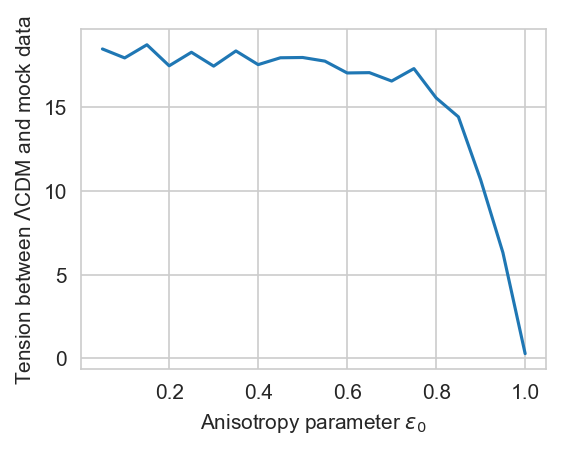

In [61]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)

ax.plot(e_values, sigmas_e)
#plt.xscale('log')
ax.set_xlabel('Anisotropy parameter $\epsilon_0$')
ax.set_ylabel('Tension between $\Lambda$CDM and mock data')
plt.show()

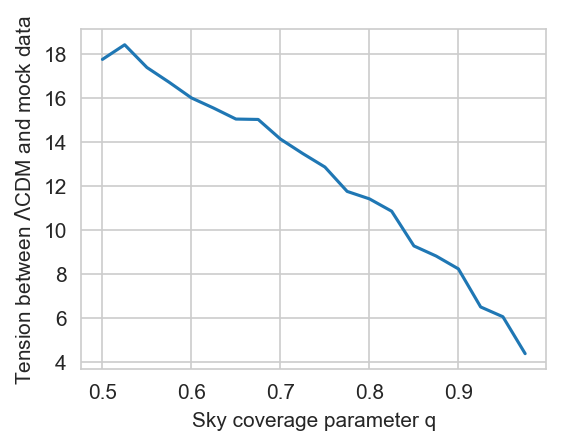

In [62]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)

ax.plot(q_values, sigmas_q)
#plt.xscale('log')
ax.set_xlabel('Sky coverage parameter q')
ax.set_ylabel('Tension between $\Lambda$CDM and mock data')
plt.show()

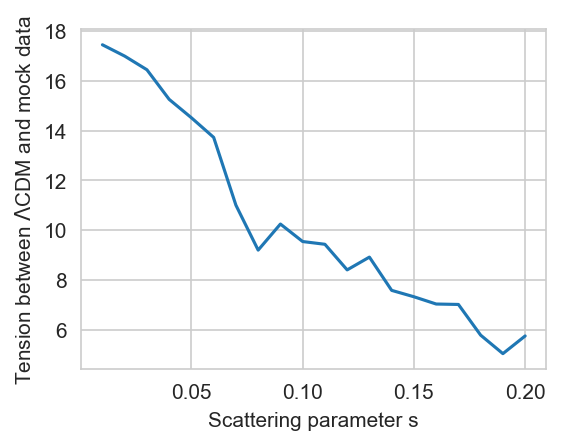

In [63]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)

ax.plot(s_values, sigmas_s)
#plt.xscale('log')
ax.set_xlabel('Scattering parameter s')
ax.set_ylabel('Tension between $\Lambda$CDM and mock data')
plt.show()

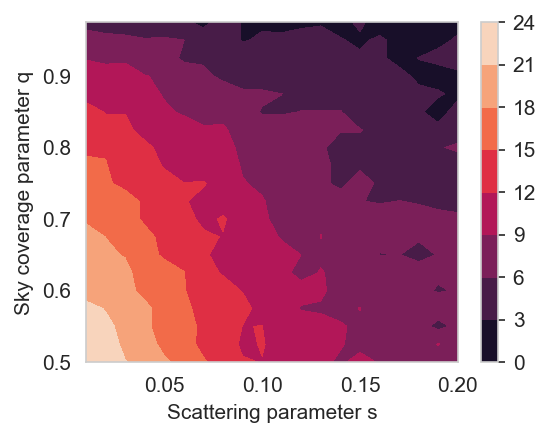

In [64]:
S1, Q1 = np.meshgrid(s_values, q_values)
Sig1 = np.array(sigmas_qs).reshape(len(q_values), len(s_values))

fig, ax = plt.subplots(figsize=(4,3), dpi=150)

plt.contourf(S1, Q1, Sig1)
ax.set_xlabel('Scattering parameter s')
ax.set_ylabel('Sky coverage parameter q')
plt.colorbar()
plt.show()

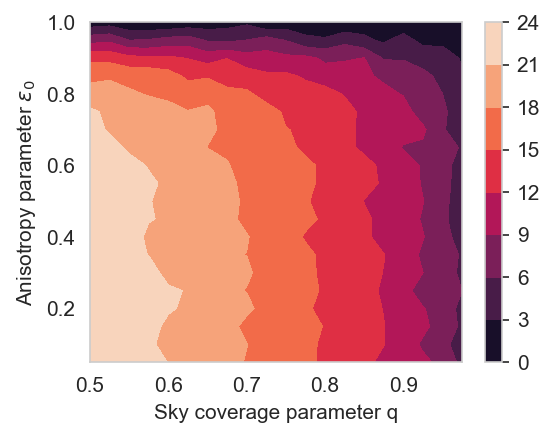

In [65]:
Q2, E1 = np.meshgrid(q_values, e_values)
Sig2 = np.array(sigmas_qe).reshape(len(e_values), len(q_values))

fig, ax = plt.subplots(figsize=(4,3), dpi=150)

plt.contourf(Q2, E1, Sig2)
ax.set_xlabel('Sky coverage parameter q')
ax.set_ylabel('Anisotropy parameter $\epsilon_0$')
plt.colorbar()
plt.show()

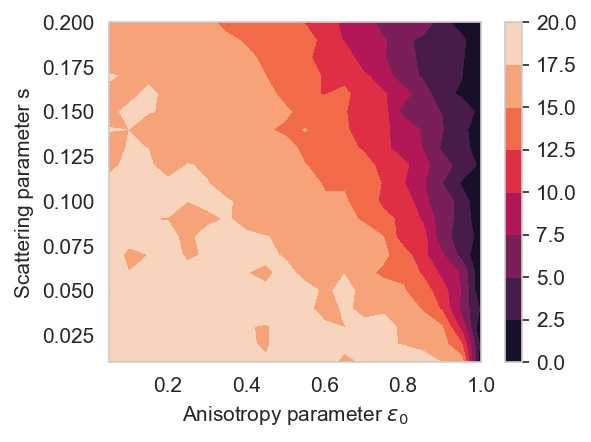

In [66]:
E2, S1 = np.meshgrid(e_values, s_values)
Sig3 = np.array(sigmas_se).reshape(len(s_values), len(e_values))

fig, ax = plt.subplots(figsize=(4,3), dpi=150)

plt.contourf(E2, S1, Sig3)
ax.set_xlabel('Anisotropy parameter $\epsilon_0$')
ax.set_ylabel('Scattering parameter s')
plt.colorbar()
plt.show()

## Case where the anisotropic direction is not aligned with the z-axis

In [67]:
def rot(a, b):
    """Rotation by angle a about the y-axis, followed by angle b about the z axis."""
    return np.array([[np.cos(b)*np.cos(a), -np.sin(b), np.cos(b)*np.sin(a)], 
                     [np.sin(b)*np.cos(a), np.cos(b), np.sin(b)*np.sin(a)], 
                     [-np.sin(a), 0, np.cos(a)]])

In [68]:
I = np.round(rot(2*np.pi, 2*np.pi),2)
print(I)

[[ 1.  0. -0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]


In [69]:
def dl_anis_rot(z, theta, phi, a=np.pi/2, b=np.pi, e0=0.84):
    """The luminosity distance in the anisotropic (tanh) model as a function of redshift and the polar angles. The
    angles a and b give the anisotropic direction."""
    vec = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    vec_prime = np.matmul(rot(a, b), vec)
    return dl_lcdm(z) * np.sqrt(Eps(0, e0=e0)**4/Eps(z, e0=e0)**2 * (vec_prime[0]**2 + vec_prime[1]**2) 
                                + vec_prime[2]**2)